<a href="https://colab.research.google.com/github/newcave/corona19/blob/main/0307_othercountry_corona19_confirmed_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
from fbprophet import Prophet
from fbprophet.plot import plot_plotly,add_changepoints_to_plot
import numpy as np

# Load Dataset

In [2]:
# Confirmation, recovery, and death data sets by region worldwide
# 전세계 지역별 확진자, 회복자, 사망자 Data Set
url = 'https://raw.githubusercontent.com/datasets/covid-19/master/data/time-series-19-covid-combined.csv'
data = pd.read_csv(url, error_bad_lines=False)

# Understanding the structure of the data set
# Data Set의 구조 파악
data


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning:

The error_bad_lines argument has been deprecated and will be removed in a future version.





,Date,Country/Region,Province/State,Confirmed,Recovered,Deaths
0,2020-01-22,Afghanistan,NaN,0,0.0,0
1,2020-01-23,Afghanistan,NaN,0,0.0,0
2,2020-01-24,Afghanistan,NaN,0,0.0,0
3,2020-01-25,Afghanistan,NaN,0,0.0,0
4,2020-01-26,Afghanistan,NaN,0,0.0,0
...,...,...,...,...,...,...
220095,2022-03-02,Zimbabwe,NaN,237503,0.0,5396
220096,2022-03-03,Zimbabwe,NaN,237503,0.0,5396
220097,2022-03-04,Zimbabwe,NaN,238739,0.0,5397
220098,2022-03-05,Zimbabwe,NaN,239019,0.0,5397


# Make it Simple

In [3]:
# Make Korea's confirmed cases timeseries dataframe
# 한국의 확진자 시계열 데이터프레임를 확인합니다

df_korea = data[data['Country/Region'] == 'Korea, South']
df_korea = np.column_stack([df_korea.Date, df_korea.Confirmed])
df_korea = pd.DataFrame(df_korea)

df_korea.tail()

,0,1
770,2022-03-02,3691488
771,2022-03-03,3958326
772,2022-03-04,4212652
773,2022-03-05,4456264
774,2022-03-06,4666977


In [4]:
df_korea = df_korea.iloc[550:] #550   # 680 3/14   # 650 3/23   # 
df_korea

,0,1
550,2021-07-25,190166
551,2021-07-26,191531
552,2021-07-27,193427
553,2021-07-28,195099
554,2021-07-29,196806
...,...,...
770,2022-03-02,3691488
771,2022-03-03,3958326
772,2022-03-04,4212652
773,2022-03-05,4456264


In [5]:
df_korea = df_korea.reset_index().rename(columns={0: 'date', 1: 'confirmed'})
df_korea = df_korea.drop("index", axis=1)
###
#df_korea = df_korea[1:10,0:1,0]

###
#df_korea = df_korea.append([{'date': pd.to_datetime('2022-03-05'), 'confirmed': 4000897}], ignore_index=True)
#df_korea = df_korea.append([{'date': '2022-03-04', 'confirmed': 4121653}], ignore_index=True)


df_korea.tail()

,date,confirmed
220,2022-03-02,3691488
221,2022-03-03,3958326
222,2022-03-04,4212652
223,2022-03-05,4456264
224,2022-03-06,4666977


In [ ]:
df_korea['date'].nunique

df_korea['date'].value_counts()

2021-07-25    1
2021-07-26    1
2021-12-14    1
2021-12-15    1
2021-12-16    1
             ..
2021-10-11    1
2021-10-12    1
2021-10-13    1
2021-10-14    1
2022-03-05    1
Name: date, Length: 224, dtype: int64

In [ ]:
df_korea.iloc[3]

date         2021-07-28
confirmed        195099
Name: 3, dtype: object

# Plot

In [6]:
# Plot Korean COVID19 confirmed cases.
# 한국 코로나19 확진자 트렌드를 그래프로 만듭니다.

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=df_korea.date,
        y=df_korea.confirmed,
        name='Confirmed in Korea'
    )
)

fig

# Facebook Prophet

In [7]:
# Make dataframe for Facebook Prophet prediction model.
# Facebook Prophet 예측 모델에 넣을 데이터프레임을 만들어줍니다.
df_prophet = df_korea.rename(columns={
    'date': 'ds',
    'confirmed': 'y'
})

df_prophet.tail()

,ds,y
220,2022-03-02,3691488
221,2022-03-03,3958326
222,2022-03-04,4212652
223,2022-03-05,4456264
224,2022-03-06,4666977


# Create a Model

# Add changepoints to Make More Flexible
- https://facebook.github.io/prophet/docs/trend_changepoints.html

In [10]:
# Make Prophet model including daily seasonality
# Prophet에서 감안할 계절성을 선택해서 모델을 만듭니다
m = Prophet(
    changepoint_prior_scale=0.95, # increasing it will make the trend more flexible
    changepoint_range=0.85, # place potential changepoints in the first 98% of the time series
    # 0.95 & 0.85
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='additive'
)

# m.fit(df_prophet)

# #forecast2 = forecast.iloc[1:,1]-forecast.iloc[0:,1]
# #forecast2

m.fit(df_prophet)

future = m.make_future_dataframe(periods=14)
forecast = m.predict(future)

fig = plot_plotly(m, forecast)
py.iplot(fig)


# Plot changepoints

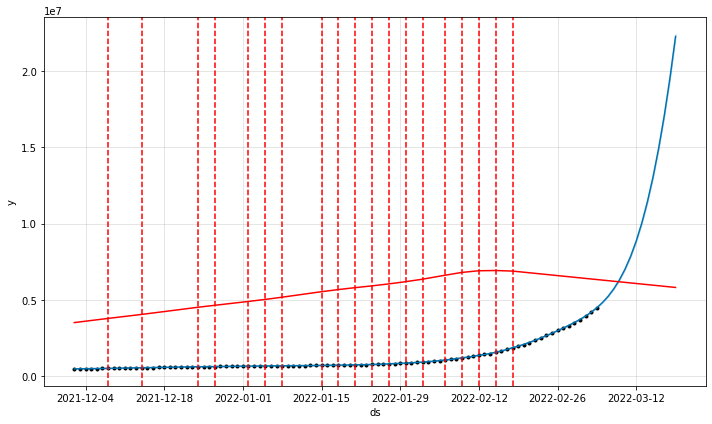

In [ ]:
# display changepoints as red dotted line on the plot.
# changepoint를 그래프에 반영해봅시다.
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)